## Retrieving Expression Matrices from the DCP

Data in the DCP is organized in "bundles", and some of those bundles contain expression matrices that have been produced using HCA analysis pipelines. Those matrices can be downloaded directly, but the DCP also provides a "matrix service" that handles aggregation, format conversion, and (eventually) things like filters and queries.

This vignette walks through obtaining an expression matrix using the matrix service API. Note that the API has only been functional for a short time and currently doesn't support all experiment types. Also, it's very likely that the direct interaction with the API will be wrapped with something that integrates more naturally with python and R.

First, there is some boilerplate:
- Install the `hca` package
- Create a client to the HCA Data Storage System

In [1]:
import sys
!{sys.executable} -m pip install hca
import hca.dss
client = hca.dss.DSSClient()

Now, prepare a query for some bundles in the DSS. Queries are written using [Elasticsearch syntax](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl.html). The query below find bundles by experiment type and species. We find that most serious users have committed the Experimental Factor Ontology and NCBI Taxonomy Database to memory, but in case not, this finds [Smart-seq2](https://www.ebi.ac.uk/ols/ontologies/efo/terms?iri=http%3A%2F%2Fwww.ebi.ac.uk%2Fefo%2FEFO_0008931) data from [humans](https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=9606). It also only returns "analysis" bundles, that is bundles that are produced by a secondary analysis pipeline and should have an expression matrix.

In [2]:
es_query = {
  "query": {
    "bool": {
      "must": [
        {
          "match": {
            # Smart-seq2
            "files.library_preparation_protocol_json.library_construction_approach.ontology": "EFO:0008931"
          }
        },
        {
          "match": {
            "files.sequencing_protocol_json.paired_end": True
          }
        },
        {
          "match": {
            # Human
            "files.donor_organism_json.biomaterial_core.ncbi_taxon_id": 9606
          }
        },
        {
          "match": {
            # Only bundles with expression matrices
            "files.analysis_process_json.process_type.text": "analysis"
          }
        }
      ]
    }
  }
}

Now, execute the query. We'll just take the first 100 results, and we want the bundle "fully-qualified ids" to pass to the matrix service API.

In [3]:
import itertools
search_results = list(itertools.islice(client.post_search.iterate(replica="aws", es_query=es_query), 100))
bundle_fqids = [r["bundle_fqid"] for r in search_results]
print(bundle_fqids[0])

980b814a-b493-4611-8157-c0193590e7d9.2018-11-12T131442.994059Z


Submit the resulting list of bundle fqids to the matrix service. Also, for this case, request the output matrix in [loom format](https://linnarssonlab.org/loompy/index.html). The matrix service should give us a response with a `request_id` that we can use to check when the matrix is ready.

In [4]:
import json, requests
matrix_query_url = "https://matrix.data.humancellatlas.org/v0/matrix"
post_response = requests.post(matrix_query_url, data=json.dumps({"bundle_fqids": bundle_fqids, "format": "loom"}), headers={"Content-Type": "application/json"})
print(post_response.json())

{'eta': '', 'matrix_location': '', 'message': 'Job started.', 'request_id': '73de02df-7b73-456a-b84f-682e0ec3c014', 'status': 'In Progress'}


Wait until the request is ready. When it is, download the matrix from the url in the response from the matrix service. This could take a little while.

In [5]:
import os, time
while True:
    get_response = requests.get(matrix_query_url + '/' + post_response.json()["request_id"])
    if get_response.json().get("status", "In Progress") == "In Progress":
        time.sleep(10)
    else:
        break
matrix_url = get_response.json()["matrix_location"]
!wget {matrix_url}
local_matrix_path = os.path.basename(matrix_url)

--2018-11-16 16:37:22--  https://s3.amazonaws.com/dcp-matrix-service-results-prod/81f3cb0f4a66074635d419df4f0bb47369e8b3211451303557b16b9732da0393.loom
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.228.19
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.228.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4006609 (3.8M) [binary/octet-stream]
Saving to: ‘81f3cb0f4a66074635d419df4f0bb47369e8b3211451303557b16b9732da0393.loom.2’

81f3cb0f4a66074635d 100%[===================>]   3.82M  3.44MB/s    in 1.1s    

2018-11-16 16:37:24 (3.44 MB/s) - ‘81f3cb0f4a66074635d419df4f0bb47369e8b3211451303557b16b9732da0393.loom.2’ saved [4006609/4006609]



Finally, let's do something with this matrix. Here we'll open it with [scanpy](https://scanpy.readthedocs.io/en/latest/) and print a graph of this most highly expressed genes.

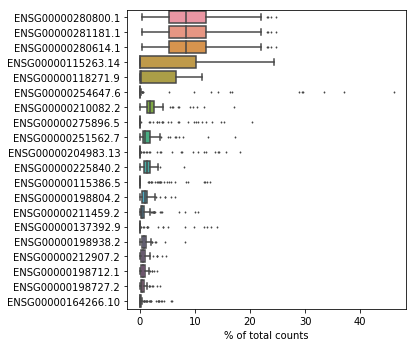

In [7]:
!{sys.executable} -m pip install scanpy
import scanpy.api as sc
adata = sc.read_loom(local_matrix_path)
sc.pl.highest_expr_genes(adata, n_top=20)